# Assignment 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

import mylib as my

## Implementing the Perceptron learning algorithm

* **(25 points)** Define a class named "Perceptron" that implements the **Perceptron** learning algorithm for binary classification, as outlined in the lecture notes. This class should resemble and behave like any SciKit-Learn estimator model, meaning it should inherit from the `sklearn.base.BaseEstimator` class. Additionally, all hyperparameters, such as the learning rate and the number of epochs, should be passed to the class constructor. The class should also include a `fit` function that takes the training data and returns `self`; this is where the perceptron algorithm is implemented. Furthermore, it should define a `predict` function that takes input data and returns their predictions.

In [2]:
class Perceptron(BaseEstimator):
    def __init__(self, epochs=100, lr=0.0001):
        self.epochs = epochs
        self.lr = lr
        self.w = []
        self.b = 0
    
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        
        for epoch in range(self.epochs):
            linear_combination = np.dot(X, self.w) + self.b
            y_pred = np.sign(linear_combination)
            
            errors = y - y_pred

            self.w += self.lr * np.dot(errors, X)
            self.b += self.lr * np.sum(errors)
        
        return self
    
    def predict(self, X):
        linear_combination = np.dot(X, self.w) + self.b
        return np.sign(linear_combination)

* **(15 points)** Show, through plotting, that your perceptron is capable of correctly classifying the outputs of the AND and OR logical functions below. Plot the data points corresponding to these functions and color them according to their output values. Additionally, visualize the decision boundaries learned by the perceptrons trained on these functions.

```
  .....AND.....
   x1   x2   y
   -1   -1  -1
   -1    1  -1
    1   -1  -1
    1    1   1
   
  .....OR .....
   x1   x2   y
   -1   -1  -1
   -1    1   1
    1   -1   1
    1    1   1
```

In [3]:
# "AND" data
X_AND = [
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
]

y_AND = [-1, -1, -1, 1]

X_AND = np.array(X_AND)
y_AND = np.array(y_AND)


# "OR" data

X_OR = [
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
]

y_OR = [-1, 1, 1, 1]

X_OR = np.array(X_OR)
y_OR = np.array(y_OR)

In [4]:
pc_AND = Perceptron().fit(X_AND, y_AND)
pc_OR = Perceptron().fit(X_OR, y_OR)

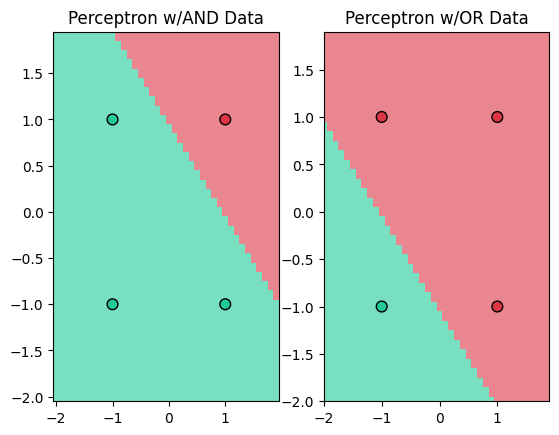

In [5]:
fig, subfigs = plt.subplots(1, 2)

my.plot_decision_regions(X=X_AND, y=y_AND, resolution=0.1, learner=pc_AND, ax=subfigs[0], title='Perceptron w/AND Data')
my.plot_decision_regions(X=X_OR, y=y_OR, resolution=0.1, learner=pc_OR, ax=subfigs[1], title='Perceptron w/OR Data')

## Multi-class logistic regression using One vs. Rest (OvR)
Some models are inherently binary classifiers. For instance, logistic regression is a binary classifier, but we can generalize it to handle multi-class classification problems using the One vs. Rest (OvR), also known as One vs. All, method. The OvR algorithm operates as follows:

If you have a dataset with C classes, you create C binary-classifier models, one for each class. The model for a class $c_i$ is trained using a modified dataset where the output for examples belonging to that class is set to 1, while the output for the rest of the examples is set to 0. When presented with an unseen example, you pass it to all these C models for prediction, and each model returns a positive probability. The final predicted class for the unseen example is determined by the model that returns the highest positive probability value.

* **(25 points)** Define a class named `OneVRest` that implements the One vs. Rest algorithm for the` LogisticRegression` model in SciKit Learn. This class should mimic a typical SciKit Learn estimator by inheriting from `sklearn.base.BaseEstimator` and should include `fit` and `predict` functions.

    **NOTE**: You can utilize the `predict_proba` method of the logistic regression model to obtain the probabilities. This method returns two probabilities for each example: one for the negative class (class 0) and one for the positive class (class 1).

In [6]:
class OneVRest(BaseEstimator):
    def __init__(self, max_iter=100, C=1.0, penalty='l2'):
        self.max_iter = max_iter
        self.C = C
        self.penalty = penalty
        self.models = {}
    
    def fit(self, X, y):
        unique_classes = list(set(y))
        
        for target_class in unique_classes:
            binary_y = [1 if label==target_class else 0 for label in y]
            
            lr = LogisticRegression(
                C=self.C,
                penalty=self.penalty,
                max_iter=self.max_iter
            )
            lr.fit(X, binary_y)
            
            self.models[target_class] = lr
        
        return self
    
    def predict(self, X):
        if isinstance(X, list):
            X = np.array(X)
        
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        
        predictions = {}
        
        for target_class, model in self.models.items():
            class_probs = model.predict_proba(X)[:, 1]
            predictions[target_class] = class_probs
        
        classes = list(predictions.keys())
        
        predicted_classes = [classes[pred.index(max(pred))] for pred in zip(*predictions.values())]
        return np.array(predicted_classes)

* **(10 points)** Using the data below, test your `OneVRest` class and plot its training decision regions. Use the `plot_decision_regions` from `mylib` for that.

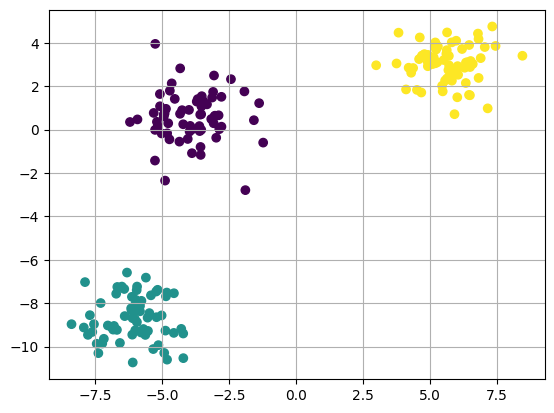

In [7]:
from sklearn.datasets import make_blobs

X, y = make_blobs(200, centers=3, n_features=2, random_state=17)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.grid()

In [8]:
ovr = OneVRest().fit(X, y)

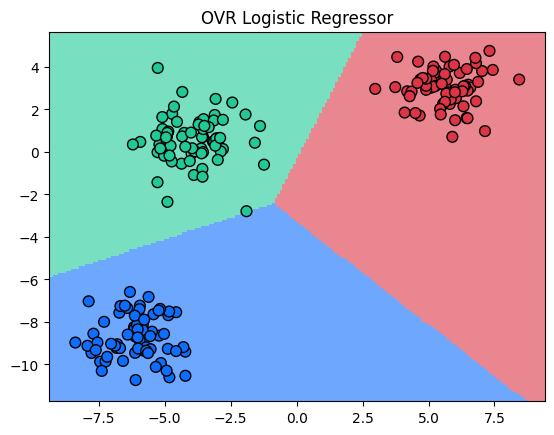

In [9]:
fig, subfigs = plt.subplots(1)

my.plot_decision_regions(X=X, y=y, resolution=0.1, learner=ovr, ax=subfigs, title='OVR Logistic Regressor')

## Fitting an MLP to the hepatitis data

In this part you will fit an MLP model to the [Hepatitis](https://archive.ics.uci.edu/dataset/46/hepatitis) dataset. This dataset is small and unbalanced. It consists of 19 input categorical and numerical features, some of which contain missing values. 

The dateset contains the following columns:

```
     1. Class: DIE, LIVE
     2. AGE: 10, 20, 30, 40, 50, 60, 70, 80              (Numerical)
     3. SEX: male, female                                (Categorical)
     4. STEROID: no, yes                                 (Categorical)
     5. ANTIVIRALS: no, yes                              (Categorical)
     6. FATIGUE: no, yes                                 (Categorical)
     7. MALAISE: no, yes                                 (Categorical)
     8. ANOREXIA: no, yes                                (Categorical)
     9. LIVER BIG: no, yes                               (Categorical)
    10. LIVER FIRM: no, yes                              (Categorical)
    11. SPLEEN PALPABLE: no, yes                         (Categorical)
    12. SPIDERS: no, yes                                 (Categorical)
    13. ASCITES: no, yes                                 (Categorical)
    14. VARICES: no, yes                                 (Categorical)
    15. BILIRUBIN: 0.39, 0.80, 1.20, 2.00, 3.00, 4.00    (Numerical)
    16. ALK PHOSPHATE: 33, 80, 120, 160, 200, 250        (Numerical)
    17. SGOT: 13, 100, 200, 300, 400, 500,               (Numerical)
    18. ALBUMIN: 2.1, 3.0, 3.8, 4.5, 5.0, 6.0            (Numerical)
    19. PROTIME: 10, 20, 30, 40, 50, 60, 70, 80, 90      (Numerical)
    20. HISTOLOGY: no, yes                               (Categorical)
```
with the first column being the output: 1 for DIE and 2 for LIVE. All input features have been converted to numeric values. And missing values are marked with a question mark `?`.

* **(5 points)** Load the data into a dataframe and print it. You can use the `my.download_zip_and_open_a_file` function to download the zip file and read a specific file from it. Name the columns of the dataframe using the above list of features. Missing values should show up as 'NaN` in the dataframe. Move the `Class` column to the end and re-code its values such that 0 is used for LIVE and 1 is used for DIE. Show the new dataframe.

    **IMPORTANT NOTE**: To access the functions from the **for-this-class-only** `mylib` package, clone or download it from **[this GitHub page](https://github.com/aalgahmi/mylib)**. You can find instructions on how to clone this package on its main GitHub page, as well as in the `04.working_with_datasets.ipynb` notebook handout. Make sure to place the `mylib` folder from this package in the same directory as this notebook. Once you've completed this step, the following import should work seamlessly.

In [10]:
import mylib as my



df = pd.read_csv(my.download_zip_and_open_a_file(url='https://archive.ics.uci.edu/static/public/46/hepatitis.zip', filename='hepatitis.data'))
df.columns = ['class', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
              'spleen_palpable', 'spiders', 'ascites', 'varices', 'bilirubin', 'alk_phosphate','sgot', 'albumin', 'protime', 'histology']
df.replace('?', np.nan, inplace=True)
df['class'] = df['class'].map({2:0, 1:1})

num_features = ['age', 'bilirubin', 'alk_phosphate','sgot', 'albumin', 'protime']
cat_features = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']

df = df[['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
              'spleen_palpable', 'spiders', 'ascites', 'varices', 'bilirubin', 'alk_phosphate','sgot', 'albumin', 'protime', 'histology', 'class']]

df.head()

age  sex steroid  antivirals fatigue malaise anorexia liver_big liver_firm  \
0   50    1       1           2       1       2        2         1          2   
1   78    1       2           2       1       2        2         2          2   
2   31    1     NaN           1       2       2        2         2          2   
3   34    1       2           2       2       2        2         2          2   
4   34    1       2           2       2       2        2         2          2   

  spleen_palpable spiders ascites varices bilirubin alk_phosphate sgot  \
0               2       2       2       2      0.90           135   42   
1               2       2       2       2      0.70            96   32   
2               2       2       2       2      0.70            46   52   
3               2       2       2       2      1.00           NaN  200   
4               2       2       2       2      0.90            95   28   

  albumin protime  histology  class  
0     3.5     NaN          1      0  
1     4.0     NaN          1      0  
2     4.0      80          1      0  
3     4.0     NaN          1      0  
4     4.0      75          1      0

* **(20 points)** Create a custom transformer class named `CustomImputer`. This class should inherit from `sklearn.base.BaseEstimator` and `sklearn.base.TransformerMixin`, and it should define two functions:

    * `fit`, which must return `self`. This function should iterate over the columns of its X parameter and populate two instance lists: `self.cat_features_` for categorical features and `self.num_features_` for numerical values. Consider a feature as categorical if the number of its possible values is <= 3.
    
    * `transform`, which should return the transformed data. It should utilize `sklearn.impute.SimpleImputer` with a 'most frequent' strategy to handle missing values in the categorical columns and another `sklearn.impute.SimpleImputer` with a 'mean' strategy to handle missing values in the numerical columns.


In [11]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_features_ = []
        self.num_features_ = []
    
    def fit(self, X, y=None):
        
        #iter over features
        for feat in range(X.shape[1]):
            #get vals for each feat
            vals = np.unique(X[:, feat])
            #check length -> cat if len <=3
            if len(vals) <=3:
                self.cat_features_.append(feat)
            else:
                self.num_features_.append(feat)
        return self
    
    def transform(self, X):
        mean_imputer = SimpleImputer(strategy='mean').fit(X[:,self.cat_features_])
        mode_imputer = SimpleImputer(strategy='most_frequent').fit(X[:,self.num_features_])
        
        X[:,self.cat_features_] = mean_imputer.transform(X[:,self.cat_features_])
        X[:,self.num_features_] = mode_imputer.transform(X[:,self.num_features_])
        return X
        

* **(5 points)** Convert the dataframe into numpy arrays and split them into training and testing sets. Show the shapes of split arrays.

In [12]:
X = df.drop('class', axis=1).values.astype(float)
y = df['class'].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'''
X train shape: {X_train.shape}
X test shape: {X_test.shape}
y train shape: {y_train.shape}
y test shape: {y_test.shape}
''')


X train shape: (107, 19)
X test shape: (47, 19)
y train shape: (107,)
y test shape: (47,)



* **(5 points)** Create a pipeline with two transformers (`CustomImputer` and `MinMaxScaler`) and an estimator (MLPClassifier). The `CustomImputer` handles missing values in the data and passes it to `MinMaxScaler` to normalize the values before training the `MLPClassifier` model. Use a `ReLU` activation function for the MLP model and enable early stopping with `n_iter_no_change` set to 5.

In [13]:
pipeline = Pipeline([
    ('imputer', CustomImputer()),
    ('scaler', MinMaxScaler()),
    ('MLP', MLPClassifier(hidden_layer_sizes=(100, 50, 100, 50), activation='relu', max_iter=1000, n_iter_no_change=5))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', CustomImputer()), ('scaler', MinMaxScaler()),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(100, 50, 100, 50),
                               max_iter=1000, n_iter_no_change=5))])

* **(5 points)** Test the trained MLP model on the testing dataset and print its accuracy, recall, precision, and F1 score. Use the appropriate functions from `sklearn.metrics` to calculate these values.

In [14]:
y_pred = pipeline.predict(X_test)

print(f'''
 Accuracy: {accuracy_score(y_test, y_pred)}
Precision: {precision_score(y_test, y_pred)}
   Recall: {recall_score(y_test, y_pred)}
       F1: {f1_score(y_test, y_pred)}
''')


 Accuracy: 0.7446808510638298
Precision: 0.5
   Recall: 0.25
       F1: 0.3333333333333333



* **(5 points)** In a figure with three subplots in a row, display the testing confusion matrix, ROC curve, and precision-recall curve.

Text(0, 0.5, 'Precision')

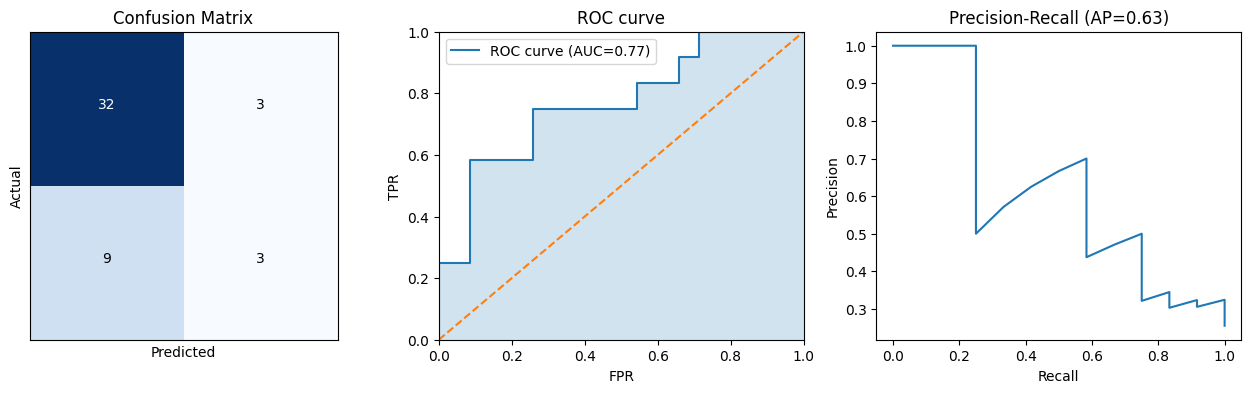

In [20]:
fig, subfigs = plt.subplots(1, 3, figsize=(16, 4))

#confusion
confusion = confusion_matrix(y_test, y_pred)
subfigs[0].imshow(confusion, cmap=plt.cm.Blues)
subfigs[0].set_title('Confusion Matrix')
subfigs[0].set_xlabel('Predicted')
subfigs[0].set_ylabel('Actual')
subfigs[0].set_xticks([])
subfigs[0].set_yticks([])
subfigs[0].set_xticklabels([])
subfigs[0].set_yticklabels([])
for i in range(2):
    for j in range(2):
        subfigs[0].text(j, i, confusion[i, j], horizontalalignment="center", color="white" if confusion[i, j] >= confusion.max() / 2 else "black")


#ROC
y_scores = pipeline.predict_proba(X_test)[:, 1]
#y_scores = y_scores[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
subfigs[1].plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.2f})')

subfigs[1].fill_between(fpr, tpr, 0, alpha=0.2)  # Adjust alpha to control the transparency of the shaded region

subfigs[1].plot([0,1],[0,1], linestyle='--')
subfigs[1].set_title('ROC curve')
subfigs[1].set_xlim([0.0, 1.0])
subfigs[1].set_ylim([0.0, 1.0])
subfigs[1].set_xlabel('FPR')
subfigs[1].set_ylabel('TPR')
subfigs[1].legend()

#Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)
subfigs[2].plot(recall, precision)#, where='post')
subfigs[2].set_title(f'Precision-Recall (AP={avg_precision:.2f})')
subfigs[2].set_xlabel('Recall')
subfigs[2].set_ylabel('Precision')